В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [83]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [84]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [85]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self):
        layer_sizes = self.layer_sizes
#         W1 = np.random.randn(n_1, n_x) * 0.01
#         b1 = np.zeros((n_1, 1))
#         W2 = np.random.randn(1, n_1) * 0.01
#         b2 = 0 # у вихідному шарі лише 1 нейрон
        params = {}
        for i in range(1, len(layer_sizes)):
            params['W' + str(i)] = np.random.randn(layer_sizes[i], layer_sizes[i - 1]) * 0.01
            params['b' + str(i)] = np.zeros((layer_sizes[i], layer_sizes[i-1]))
        self.params = params
       
    def __forward_propagation(self, X):
        params = self.params
        caches = []
        A = X
        L = len(params) // 2

        for i in range(1, len(params) + 1):
            A, cache = self.forward_activation(A, params["W"+str(i)], params["b"+str(i)])
            caches.append(cache)
        return A, caches
    
    def forward_activation(self, prevA, W, b):
        print(W)
        Z = np.dot(W, prevA) + b
        linearCache = (prevA, W, b)
        A = self.__sigmoid(Z)
        activationCache = Z
        cache = (linearCache, activationCache)
        return A, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, caches):
        grads = {}
        A = X
        L = len(caches)
        m = A.shape[1]
        Y = Y.reshape(A.shape)
        dA = -(np.divide(Y, A) - np.divide(1 - Y, 1 - A))
        
        currentCache = caches[L-1]
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = self.backward_activation(dA, currentCache)
        for i in reversed(range(len(caches)-1)):
            currentCache = caches[i]
            prevDA, dW, db = self.backward_activation(grads["dA" + str(i + 1)], currentCache)
            grads["dA" + str(i)] = prevDA
            grads["dW" + str(i + 1)] = dW
            grads["db" + str(i + 1)] = db
        return grads
    
    def backward_activation(self, dA, cache):
        linearCache, activationCache = cache
        Z = activationCache
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        prevA, W, b = linearCache
        m = prevA.shape[1]
        dW = 1 / m * np.dot(dZ, prevA.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prevDA = np.dot(W.T, dZ)
        return prevDA, dW, db
    
    def __update_parameters(self, grads):
        params = self.params
        learningRate = self.learningRate

        for i in range(len(parameters) // 2):
            params["W" + str(i+1)] = params["W" + str(i+1)] - learningRate * grads["dW" + str(i+1)]
            params["b" + str(i+1)] = params["b" + str(i+1)] - learningRate * grads["db" + str(i+1)]
            
        self.parameters = parameters

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        self.__initialize_parameters()

        for i in range(self.num_iter):
            A, caches = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, caches)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [86]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [87]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


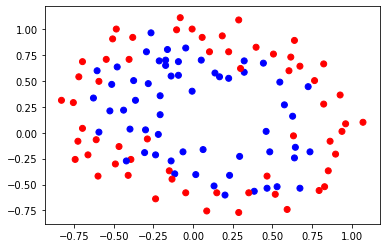

In [88]:
plot_data(X, Y)

In [89]:
cls = NeuralNet(layer_sizes=[2, 15, 1] ,normalize = True, learning_rate = 0.5, num_iter = 4000)

In [90]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

[[-0.00288222  0.01580178]
 [-0.00476073 -0.01168923]
 [ 0.0041324   0.00527742]
 [ 0.00635265  0.00974554]
 [-0.00881676  0.00392541]
 [-0.012788   -0.00593692]
 [-0.00401639 -0.00881398]
 [-0.01318929 -0.00548437]
 [-0.01321057 -0.00270318]
 [-0.00052908 -0.01056513]
 [ 0.01216436  0.02475935]
 [ 0.00914671  0.00985108]
 [-0.00092005 -0.0075821 ]
 [-0.00077566  0.0253411 ]
 [ 0.01599758  0.00078809]]


ValueError: operands could not be broadcast together with shapes (15,118) (15,2) 

In [ ]:
print(cls.parameters)

In [ ]:
Y_prob = cls.predict_proba(X)
Y_prob

In [ ]:
Y_hat = cls.predict(X)
Y_hat

In [ ]:
accuracy_score(Y, Y_hat)

In [ ]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [ ]:
clf.fit(X, Y)

In [ ]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [ ]:
accuracy_score(Y, clf.predict(X))